<a href="https://colab.research.google.com/github/ioannaoiko/Deep_Learning_for_NLP/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-01-19 11:25:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-19 11:25:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-19 11:25:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
from textblob import Word
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Loading the dataset
df = pd.read_csv("./imdb-reviews.csv", sep='\t')
df.describe()

,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


In [ ]:
#Check for null values
#In this case there are no missing values
df.isnull().sum()

url       0
rating    0
review    0
dtype: int64

In [ ]:
#data preprocessing function
def preprocessing(review):
  review = review.lower()
  review = review.replace('http\S+|www.\S+|https\S+','') #removing urls
  review = review.replace('<br />', '') #removing <br>
  review = review.replace('...', '')
  review = word_tokenize(review) #tokenization
  review = " ".join(review)

  review = ' '.join([word for word in review.split() if word not in punctuation])
  review = ' '.join([word for word in review.split() if word not in stop_words])
  review = ' '.join([word for word in review.split() if not word.isdigit()])

  review = ' '. join([word for word in review.split() if "'" not in word])
  review = ' '. join([word for word in review.split() if "`" not in word])

  return "".join(Word(word).lemmatize() for word in review)

In [ ]:
#adding boolean sentiment column to the dataset
df['sentiment'] = df['rating'] >=7

In [ ]:
df['review'] = df['review'].apply(preprocessing)

In [ ]:
df = df.drop_duplicates('review')

In [ ]:
#splitting dataset into training and validation data
training_data = df.sample(frac=0.8)
validation_data = df.drop(training_data.index)

In [ ]:
x_train = pd.DataFrame(training_data, columns=[training_data.columns[-2]])
y_train = pd.DataFrame(training_data, columns=[training_data.columns[-1]])

In [ ]:
x_val = pd.DataFrame(validation_data, columns=[validation_data.columns[-2]])
y_val = pd.DataFrame(validation_data, columns=[validation_data.columns[-1]])

**Embeddings**

In [ ]:
def embeddings(x, y, model):
  result = []

  for j in range(len(x)):
    sum=0
    review = x.iloc[j].values[0]
    for i,w in enumerate(review.split()):
      try:
        sum += model[w]
      except KeyError:
        sum += model["0"]
    label = torch.tensor(int(y.iloc[j].values[0] == True)).float()
    result.append((sum/i, label))

  return result

In [ ]:
train = embeddings(x_train, y_train, model)
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

validation = embeddings(x_val, y_val, model)
valid_loader = torch.utils.data.DataLoader(validation, batch_size=1000, shuffle=True)

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


**RNN**

In [ ]:
class RNN(nn.Module):
    """
      Wrapper module for RNN, LSTM, GRU cells using pytorch api. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, num_layers, output_size, dropout, skipconn = True, grad_clip = True):
        super(RNN, self).__init__()

        cells = {
        "RNN" : nn.RNN,
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
    }
        self.cell_type = cell_type
        self.skipconn = skipconn
        self.grad_clip = grad_clip
        if skipconn == False:
          self.rnn = cells[cell_type](         # Pick the specific model
              input_size=input_size,           # Number of features for each time step
              hidden_size=hidden_size,         # rnn hidden units
              num_layers=num_layers,
              batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
              bidirectional=True,
              dropout = dropout
          )
          if(self.rnn.bidirectional == True):
            self.out = nn.Linear(hidden_size*2, output_size) # Feed forward network
          else:
            self.out = nn.Linear(hidden_size, output_size) # Feed forward network
        else:
          layers = []
          for i in range(num_layers):
            layers.append(cells[cell_type](
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=1,
                batch_first=True,
                bidirectional=True,
                dropout = dropout
            ))
          self.rnn = nn.Sequential(*layers)
          # if(self.rnn.bidirectional == True):
          self.out = nn.Linear(hidden_size*2, output_size) # Feed forward network

          if self.skipconn:
            # Number of hidden dimensions
            self.hidden_dim = self.rnn[0].hidden_size
            # Number of hidden layers
            self.num_layers = self.rnn[0].num_layers
          else:
            self.hidden_dim = self.rnn.hidden_size
            self.num_layers = self.rnn.num_layers
          # else:
          #   self.out = nn.Linear(hidden_size, output_size) # Feed forward network

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)

        if self.cell_type == 'LSTM':
          if self.skipconn:
            r_out, (h_n, h_c) = self.rnn[0](x)
          else:
            r_out, (h_n, h_c) = self.rnn(x)
        else:
          if self.skipconn:
            r_out, h_n = self.rnn[0](x)
          else:
            r_out, h_n = self.rnn(x)

        if self.skipconn:
          for i in range(0,self.num_layers-1):
            output1 = r_out
            out, h_n = self.rnn[i](r_out)
            output, h_n = self.rnn[i+1](out)
            r_out = output + output1


        # choose r_out at the last time step
        out = self.out(r_out)
        return out

In [ ]:
input_size = 300
hidden_size = 64
num_layers = 4
output_size = 10
dropout = 0.8
cell_type = 'LSTM'
net = RNN(cell_type, input_size, hidden_size, num_layers, output_size, dropout)
print(net)

RNN(
  (rnn): Sequential(
    (0): LSTM(300, 64, batch_first=True, dropout=0.8, bidirectional=True)
    (1): LSTM(300, 64, batch_first=True, dropout=0.8, bidirectional=True)
    (2): LSTM(300, 64, batch_first=True, dropout=0.8, bidirectional=True)
    (3): LSTM(300, 64, batch_first=True, dropout=0.8, bidirectional=True)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
EPOCH = 3
LR = 0.01

optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Remove the channel dimension
for step, (x_val, y_val) in enumerate(valid_loader):
    x_val = x_val.view(x_val.size(0), -1)
    pass
print(x_val.shape, y_val.shape)

torch.Size([933, 300]) torch.Size([933])


**Training**

Epoch:  0 | train loss: 2.3426 | test accuracy: 0.50
Epoch:  0 | train loss: 0.4969 | test accuracy: 0.75
Epoch:  0 | train loss: 0.4938 | test accuracy: 0.81
Epoch:  0 | train loss: 0.3214 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4117 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3494 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4438 | test accuracy: 0.84
Epoch:  0 | train loss: 0.3832 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4510 | test accuracy: 0.82
Epoch:  0 | train loss: 0.2557 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3291 | test accuracy: 0.82
Epoch:  0 | train loss: 0.3730 | test accuracy: 0.84
Epoch:  1 | train loss: 0.3817 | test accuracy: 0.84
Epoch:  1 | train loss: 0.3227 | test accuracy: 0.83
Epoch:  1 | train loss: 0.4956 | test accuracy: 0.84
Epoch:  1 | train loss: 0.4000 | test accuracy: 0.84
Epoch:  1 | train loss: 0.2794 | test accuracy: 0.85
Epoch:  1 | train loss: 0.2393 | test accuracy: 0.84
Epoch:  1 | train loss: 0.3209 | test accuracy

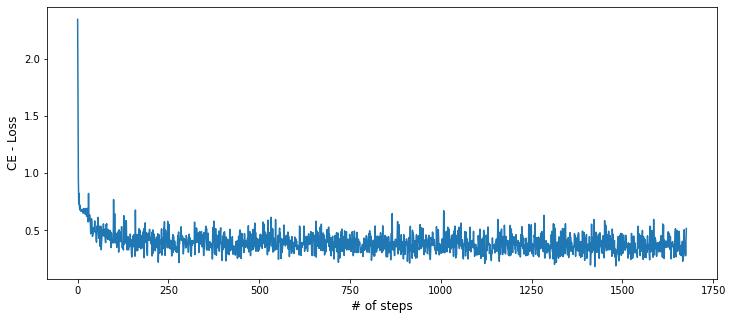

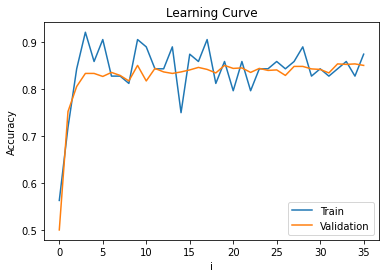

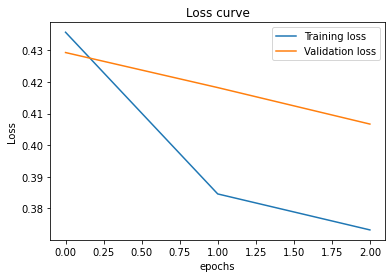

In [ ]:
# Start train mode
net.train()

# Accumulate losses
losses = []
train_losses = []
valid_losses = []
# Count the number of batches given to the model
step_count = 0

# Evaluate the progress every # batches
print_every = 50

pred = []
train_acc = []
val_acc = []
i = 0
# Iterate over the whole dataset for one epoch
for epoch in range(EPOCH):
    loss_sum = 0
    # Generate batch data
    for step, (x, y) in enumerate(train_loader):

        # clear gradients for this training step
        optimizer.zero_grad()

        b_x = x.view(x.size(0), -1)

        # batch y
        b_y = y
        b_y = b_y.type(torch.LongTensor)

        output = net(b_x)

        loss = loss_func(output, b_y)
        losses.append(loss.item())
        loss_sum += loss.item()
        # For visualization

        if net.grad_clip == True:
          torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0, norm_type=2)
        step_count += 1


        # backpropagation - compute gradients
        loss.backward()

        # apply gradients
        optimizer.step()

        # evaluate every N batches
        if step % print_every == 0:
            i+=1
            # Do not calculate gradients
            with torch.no_grad():
                output = net(b_x)
                pred_y = torch.argmax(output, dim=1).squeeze()
                accuracy_train = accuracy_score(b_y, pred_y)
                train_acc.append(accuracy_train)
                # Faster inference
                net.eval()

                test_output = net(x_val)

                # Get predicted class
                pred_y = torch.argmax(test_output, dim=1).squeeze()

                pred = pred_y
                # Calculate accuracy
                accuracy_val = accuracy_score(y_val,pred_y)
                val_acc.append(accuracy_val)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy_val)

            # Return to training mode
            net.train()
    loss_sum = loss_sum/step
    train_losses.append(loss_sum)

    loss_sum = 0
    with torch.no_grad():
      for step, (x, y) in enumerate(valid_loader):
        b_x = x.view(x.size(0), -1)

        # batch y
        b_y = y
        b_y = b_y.type(torch.LongTensor)

        output = net(b_x)

        loss_sum += loss_func(output, b_y)

    loss_sum = loss_sum/step
    valid_losses.append(loss_sum)



# Plot results
plt.figure(figsize=(12,5))
plt.plot(losses)
plt.xlabel('# of steps', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

plt.title("Learning Curve")
plt.plot([j for j in range(i)], train_acc, label="Train")
plt.plot([j for j in range(i)], val_acc, label="Validation")
plt.xlabel("i")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.plot([i for i in range(EPOCH)], train_losses, label = "Training loss")
plt.plot([i for i in range(EPOCH)], valid_losses, label = "Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.show()

In [ ]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84       466
         1.0       0.82      0.90      0.86       467

    accuracy                           0.85       933
   macro avg       0.85      0.85      0.85       933
weighted avg       0.85      0.85      0.85       933



**ROC Curve**

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

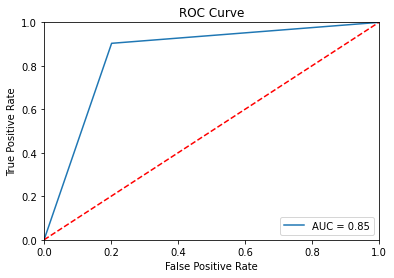

In [ ]:
fpr, tpr, threshold = roc_curve(y_val, pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

**You can use the next parts for testing**

In [ ]:
#Loading the testset
test_set = pd.read_csv("place test set here", sep='\t')

#adding boolean sentiment column to the dataset
test_set['sentiment'] = test_set['rating'] >=7
test_set['review'] = test_set['review'].apply(preprocessing)
test_set = test_set.drop_duplicates('review')


In [ ]:
x_test = pd.DataFrame(test_set, columns=[test_set.columns[-2]])
y_test = pd.DataFrame(test_set, columns=[test_set.columns[-1]])

In [ ]:
test = embeddings(x_test, y_test, model)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True)

In [ ]:
for step, (x_test, y_test) in enumerate(test_loader):
    x_test = x_test.view(x_test.size(0), -1)
    pass
print(x_test.shape, y_test.shape)

In [ ]:
output = net(x_test)
pred_y = torch.argmax(output, dim=1).squeeze()
print(classification_report(y_test, pred_y))